<a href="https://colab.research.google.com/github/TeoGM97/Regresion-con-Redes-Neuronales/blob/master/Resolver_Problema_de_Regresion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.datasets import boston_housing
from keras import layers, models, optimizers

In [2]:
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

57026/57026 [==============================] - 0s 0us/step


In [3]:
train_data.shape

(404, 13)

In [4]:
train_labels.shape

(404,)

In [5]:
train_data[0] #Caracteristicas de la casa

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

In [6]:
train_labels[0] #Precio de la casa

15.2

El problema ahora, es que algunos valores estan mucho mas alto. Debemos **normalizar** los datos.

Una de las maneras de hacerlo es restar la media y dividir por la desviacion estandar

In [7]:
mean = train_data.mean(axis=0)
train_data = train_data - mean
std = train_data.std(axis=0)
train_data = train_data / std

test_data = test_data - mean #No se saca la media ni el std de los datos de testeo porque se supone que no la tengo inicialmente.
test_data = test_data / mean #... Solo se debería usar la data de entrenamiento para crear estas mediciones


Ahora vamos a crear una funcion que sea capaz de entregar modelos de datos. Vamos a hacer crossvalidation. Es decir, ir rotando mi set de validacion en todo mi set de entrenamiento


In [18]:
def build_model_regression(lr_var, input_data):
  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_shape=(input_data,))) #input_data, con la coma porque no es un entero.
  model.add(layers.Dense(64, activation='relu'))
  model.add(layers.Dense(1)) #Capa de resultado. No es de clasificacion sino que va a dar un numero continuo. Tiene una estructura lineal. No necesito una capa de activacion

  model.compile(optimizer = optimizers.RMSprop(lr=0.001), loss='mse', metrics = ['mae'])
  return model

Sigue la iteracion del set de entrenamiento en el set de activacion

In [57]:
k = 4
num_val_samples = len(train_data) // k
num_epoch = 65
all_history = []

In [58]:
valor = 2
(valor) * num_val_samples

202

In [59]:
from numpy.core.memmap import ndarray
for i in range(k):
  print("Fold:", i)
  val_data = train_data[i*num_val_samples : (i+1) * num_val_samples]
  val_targets = train_labels[i*num_val_samples : (i+1) * num_val_samples]

  partial_train_data = np.concatenate(
      [train_data[:i * num_val_samples],
       train_data[(i+1) * num_val_samples:]
       ],
       axis=0)
  
  partial_train_targets = np.concatenate(
      [train_labels[:i * num_val_samples],
       train_labels[(i+1) * num_val_samples:]
       ],
       axis=0)

  model = build_model_regression(0.001, 13)
  history = model.fit(partial_train_data, partial_train_targets, 
                      epochs= num_epoch,
                      batch_size = 16,
                      validation_data=(val_data, val_targets),
                      verbose = 0
                      )
  #Habiamos creado una lista vacia (all_history) para guardar toda la informacion del modelo en cada iteracion

  all_history.append(history.history['val_mae'])

Fold: 0
Fold: 1
Fold: 2
Fold: 3


Recapitulando lo que se ha hecho hasta ahora:
Creamos una red neuronal en una funcion y esa red la vamos a invocar en cada iteracion de nuestro kfoldvalidation porque quiero 4 distintos entrenamientos con el set de validacion en una posicion distinta. Luego voy a promediar los errores y ver el resultado de la funcion.

Ahora vamos a ver que hizo:

In [60]:
len(all_history[0]) #Son 4 lotes de valores 80 porque tenemos 80 epocas.

65

Ya tenemos una red capaz de entregar un modelo, iterarlo para hacer la validacion y entregarle los resultados a una lista.

Ahora queda sacar los valores medios para ver el comportamiento y graficarlos para comparar con los valores reales 

In [61]:
all_mae_avg = pd.DataFrame(all_history).mean(axis=0)
all_mae_avg

0     19.583513
1     16.238463
2     12.117311
3      8.160745
4      6.119881
        ...    
60     2.340958
61     2.342951
62     2.355083
63     2.354846
64     2.285376
Length: 65, dtype: float64

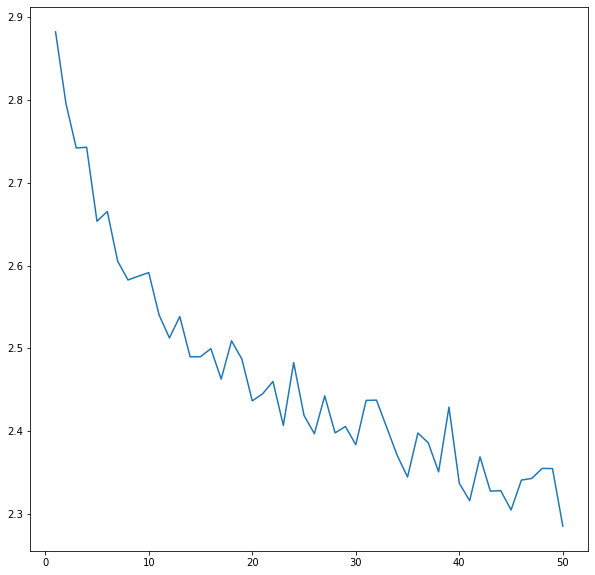

In [62]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,10))
plt.plot(range(1,len(all_mae_avg[15:])+1), all_mae_avg[15:])
plt.show()

In [64]:
model.evaluate(test_data, test_labels)

4/4 [==============================] - 0s 3ms/step - loss: 235.1766 - mae: 9.3623


[235.17660522460938, 9.362295150756836]